# 液压机械系统的频域分析

以某主燃油调节系统为例，介绍基于模拟扫频试验和传递函数拟合的频域分析方法（即动态系统线性化方法）。该方法主要包括**模拟扫频试验**、**正弦函数拟合**、**传递函数拟合**共三部分内容。

## 模拟扫频试验
扫频试验是通过对比系统输入输出信号在不同频率下幅值和相位的变化，获得其频率响应特性的一种技术手段。模拟扫频试验即通过数字仿真的方式实现该试验。

### 分析对象简介
1. 输入：伺服阀电流
2. 输出：计量活门作动筒位移、计量流量
3. 工作状态划分：按计量活门作动筒位移，从最小到最大划分共n个状态

### 扫频初始化过程的输入信号设计
仿真初始1s内，通过构造输入信号，使燃油调节系统在正式开始扫频实验时处于不同的稳定工作状态。

### 模拟扫频试验实现
1. 初始化环境+载入模型

In [3]:
from OMPython import OMCSessionZMQ
from OMPython import ModelicaSystem
import matplotlib.pyplot as plt
import numpy as np
import scipy
work_path = OMCSessionZMQ().sendExpression("cd()")
mod = ModelicaSystem(work_path+"/MFSYS7_test.mo","MFSYS7_test",[work_path+"/../CL4CSM/package.mo",work_path+"/MFSYS7.mo","Modelica"])

2021-08-02 11:52:12,758 - OMPython - INFO - OMC Server is up and running at file:///C:/Users/shubo/AppData/Local/Temp/openmodelica.port.6571774e93a74255a404e675cdc3ab6a pid=4932
2021-08-02 11:52:13,277 - OMPython - INFO - OMC Server is up and running at file:///C:/Users/shubo/AppData/Local/Temp/openmodelica.port.c2e07f6e7f3e492ea44ecf95b921f3da pid=10884


[C:/Users/shubo/Desktop/ModelicaProjects/JL-OM_Examples//CL4CSM/Hydro_Mech_Library/Boundary/package.order:0:0-0:0:readonly] Warning: The package.order file does not list all .mo files and directories (containing package.mo) present in its directory.
Missing names are:
        T_q_Boundary
        T_Boundary
[C:/Users/shubo/Desktop/ModelicaProjects/JL-OM_Examples/CL4CSM/Hydro_Mech_Library/Examples/package.mo:28:1-57:23:writable] Warning: Got element thermal_convection that was not referenced in the package.order file.
[C:/Users/shubo/Desktop/ModelicaProjects/JL-OM_Examples//CL4CSM/Hydro_Mech_Library/Examples/package.order:0:0-0:0:readonly] Warning: The package.order file does not list all .mo files and directories (containing package.mo) present in its directory.
Missing names are:
        CentriPump_deltaT



2. 设置初始化上电时间t_ik(s)，扫频频率freq(Hz)，仿真时长stop_time(s)。其中，仿真时长为初始化时间1s加扫频频率下10个正弦周期的时间之和。

In [4]:
t_ik = 0.3
freq = 5
stop_time = 1 + 10 * 1 / freq

3. 设置模型和仿真参数

In [5]:
mod.setParameters( ["pulse_time="+str(t_ik), "sin_freq="+str(freq), "sin_amp="+str(0.0003*freq)] )
mod.setSimulationOptions( ["stopTime="+str(stop_time), "stepSize="+str(0.01/freq), "solver=dassl"])
#mod.setSimulationOptions( ["stopTime="+str(stop_time), "stepSize=5e-5", "solver=rungekutta"])
print(mod.getParameters( ["pulse_time", "sin_freq", "sin_amp"] ))
print(mod.getSimulationOptions())
#mod.getParameters()

['0.3', '5', '0.0014999999999999998']
{'startTime': '0', 'stopTime': '3.0', 'stepSize': '0.002', 'tolerance': '1e-006', 'solver': 'dassl'}


4. 实施仿真

In [6]:
mod.simulate()

5. 获取仿真结果，打印点数和变量数

In [7]:
res = mod.getSolutions(["time","exportfmu.u","exportfmu.JLHM.x"])
pt_num = np.size(res,1)
var_num = np.size(res,0)
print("Point number: " + str(pt_num) + ", variable number: " + str(var_num) )

Point number: 1738, variable number: 3


6. 仿真结果绘图：电流输入和作动筒位移

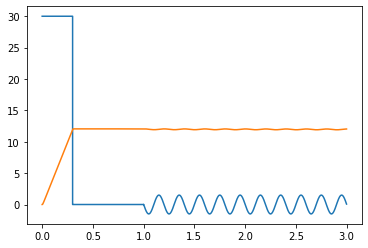

In [8]:
plt.plot(res[0,:], -res[1,:]*1000)
plt.plot(res[0,:], res[2,:]*1000)
plt.show()

7. 截取第2个波至仿真结束的数据，绘图

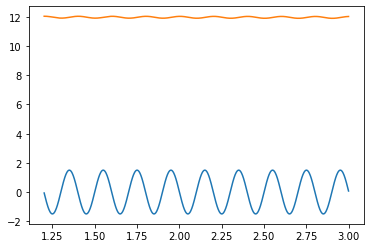

In [9]:
res_rf = [res[i , j] for i in range(var_num) for j in range(pt_num) if res[0 , j] > 1 + 1/freq ]
rst_num = int(len(res_rf) / var_num)
res_rf = np.array(res_rf).reshape(var_num, rst_num)
plt.plot(res_rf[0,:], -res_rf[1,:]*1000)
plt.plot(res_rf[0,:], res_rf[2,:]*1000)
plt.show()

## 正弦函数拟合
1. 载入科学计算库，定义误差函数

In [10]:
from scipy.optimize import leastsq
def residuals(p, f, y, t):
    A, theta, bias = p
    return y - A * np.sin(2*np.pi*f*t + theta) - bias

2. 定义初猜值p0 = [A, theta]，最小二乘拟合

In [11]:
p0 = [0.001, 0, 0]
para_input = leastsq(residuals, p0, args=(freq,res_rf[1,:],res_rf[0,:]))
para_output = leastsq(residuals, p0, args=(freq,res_rf[2,:],res_rf[0,:]))
print(para_input)
print(para_output)

(array([ 1.50033096e-03, -3.34364457e-02,  2.42633477e-08]), 1)
(array([6.38398997e-05, 7.71106961e+00, 1.19765059e-02]), 2)


3. 拟合结果与原始数据绘图：输入 & 输出

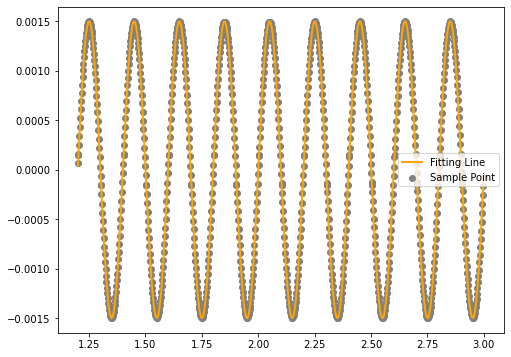

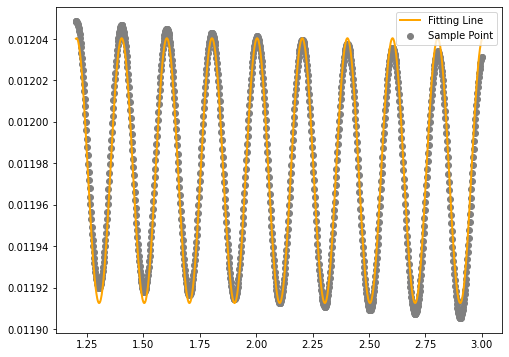

In [12]:
plt.figure(figsize=(8,6))
plt.scatter(res_rf[0,:],res_rf[1,:],color="grey",label="Sample Point",linewidth=1)
y = para_input[0][0]*np.sin(2*np.pi*freq*res_rf[0,:]+para_input[0][1])+para_input[0][2]
plt.plot(res_rf[0,:],y,color="orange",label="Fitting Line",linewidth=2)
plt.legend()
plt.show()
plt.figure(figsize=(8,6))
plt.scatter(res_rf[0,:],res_rf[2,:],color="grey",label="Sample Point",linewidth=1)
y = para_output[0][0]*np.sin(2*np.pi*freq*res_rf[0,:]+para_output[0][1])+para_output[0][2]
plt.plot(res_rf[0,:],y,color="orange",label="Fitting Line",linewidth=2)
plt.legend()
plt.show()

4. 计算当前频率下的增益(dB)和相位差(rad)

In [13]:
magnitude = 20 * np.log10( para_output[0][0] / para_input[0][0] )
phase = (para_output[0][1] - para_input[0][1])
print( str(magnitude) + "  &  " + str(phase) )

-27.421897503671822  &  7.744506057857986


5. 在不同频率下重复上述步骤，获得增益和相位点对（合并上述代码）

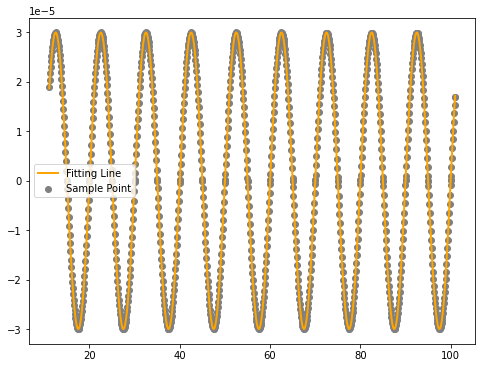

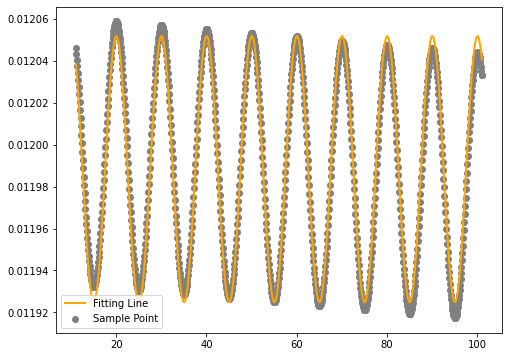

0.4688349231433768  &  -90.24610225045167
-7.426405597816382  &  -90.01328222890493
-13.441686739302867  &  -91.66560934082688
-19.461455687933768  &  -92.81642247963026
-27.421897503671822  &  -96.27248847123845
-33.46141694519028  &  -102.04445459697553
-39.58493431895227  &  -113.60803936690326
-48.65110307099724  &  -148.88383791263766


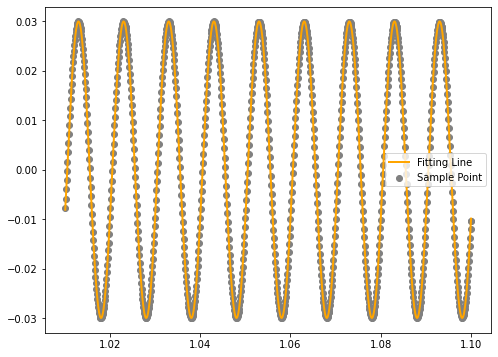

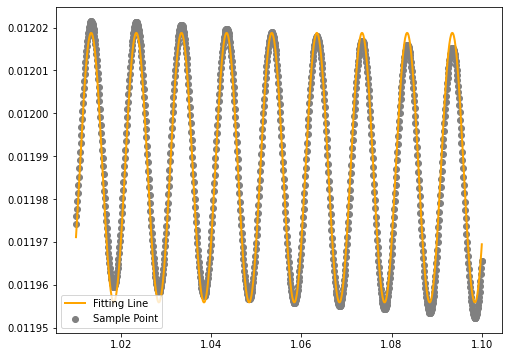

In [14]:
freq_tab = [0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100]
freq_tab_size = np.size(freq_tab) 
rcd = np.zeros((freq_tab_size, 2))

for k in range( freq_tab_size ) :
    
    freq = freq_tab[ k ]
    stop_time = 1 + 10 * 1 / freq
    mod.setParameters( ["pulse_time="+str(t_ik), "sin_freq="+str(freq), "sin_amp="+str(0.0003*freq)] )
    mod.setSimulationOptions( ["stopTime="+str(stop_time), "stepSize="+str(0.01/freq), "solver=dassl"])
    mod.simulate()
    res = mod.getSolutions(["time","exportfmu.u","exportfmu.JLHM.x"])
    
    pt_num = np.size(res,1)
    var_num = np.size(res,0)
    res_rf = [res[i , j] for i in range(var_num) for j in range(pt_num) if res[0 , j] > 1 + 1/freq ]
    rst_num = int(len(res_rf) / var_num)
    res_rf = np.array(res_rf).reshape(var_num, rst_num)
    
    p0 = [0.001, 0, 0]
    para_input = leastsq(residuals, p0, args=(freq,res_rf[1,:],res_rf[0,:]))
    para_output = leastsq(residuals, p0, args=(freq,res_rf[2,:],res_rf[0,:]))
    magnitude = 20 * np.log10( para_output[0][0] / para_input[0][0] )
    phase = ( para_output[0][1] - para_input[0][1] + np.pi) % (2*np.pi) - 2*np.pi
    rcd[k,:] = [magnitude, np.degrees(phase)]
    
    if k == 0 or k == freq_tab_size - 1 : 
        
        plt.figure(figsize=(8,6))
        plt.scatter(res_rf[0,:],res_rf[1,:],color="grey",label="Sample Point",linewidth=1)
        y = para_input[0][0]*np.sin(2*np.pi*freq*res_rf[0,:]+para_input[0][1])+para_input[0][2]
        plt.plot(res_rf[0,:],y,color="orange",label="Fitting Line",linewidth=2)
        plt.legend()
        plt.show()
        plt.figure(figsize=(8,6))
        plt.scatter(res_rf[0,:],res_rf[2,:],color="grey",label="Sample Point",linewidth=1)
        y = para_output[0][0]*np.sin(2*np.pi*freq*res_rf[0,:]+para_output[0][1])+para_output[0][2]
        plt.plot(res_rf[0,:],y,color="orange",label="Fitting Line",linewidth=2)
        plt.legend()
        plt.show() 
    
    else:
        
        print(str(magnitude)+"  &  "+str(np.degrees(phase)))

6. 在伯德图上描点

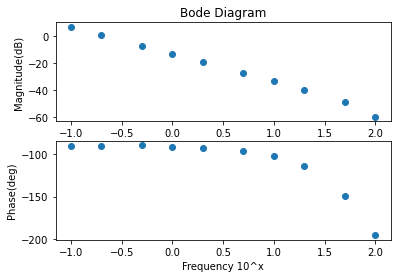

In [15]:
plt.subplot(2,1,1)
w = freq_tab
x = np.log10( w )
y = rcd[:, 0]
plt.scatter(x, y)
plt.ylabel('Magnitude(dB)')
plt.title('Bode Diagram')
    
plt.subplot(2,1,2)
y = rcd[:, 1]
plt.scatter(x, y)
plt.xlabel('Frequency 10^x')
plt.ylabel('Phase(deg)')
plt.show()

## 拟合传递函数

### 一节惯性环节

1. 定义拟合一节惯性环节的残差函数residuals_tf1

In [16]:
def residuals_tf1(tau, omega, y1, y2):
    e1 = 20 * np.log10( 1/np.sqrt((omega*tau)**2+1) ) - y1
    e2 = -np.arctan(omega*tau) - y2
   
    return e1**2 + e2**2

2. 最小二乘拟合

In [17]:
tau0 = 1
para_tf = leastsq(residuals_tf1, tau0, args=((freq_tab,rcd[:,0],rcd[:,1])))

if para_tf[1] in [1,2,3,4]:
    print("拟合成功！")
else:
    print("拟合失败！")
print("G(s)=1/Ts+1, where T = "+str(para_tf[0][0]))

拟合成功！
G(s)=1/Ts+1, where T = 6.612290853280839


3. 绘图对比

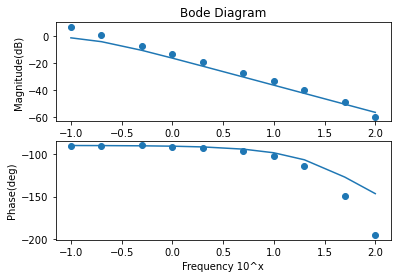

In [18]:
plt.subplot(2,1,1)
w = freq_tab
x = np.log10( w )
y1 = rcd[:, 0]
y2 = 20 * np.log10( 1/np.sqrt((freq_tab*para_tf[0])**2+1) )
plt.scatter(x, y1)
plt.plot(x, y2)
plt.ylabel('Magnitude(dB)')
plt.title('Bode Diagram')
    
plt.subplot(2,1,2)
y1 = rcd[:, 1]
y2 = -np.degrees( np.pi-np.arctan(freq_tab*para_tf[0]))
plt.scatter(x, y1)
plt.plot(x[::-1], y2)
plt.xlabel('Frequency 10^x')
plt.ylabel('Phase(deg)')
plt.show()